In [1]:
#Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os 

ovitrap = pd.read_csv("C:/Users/Patrick/Downloads/ovitrap_data_202150109.csv")
dengue = pd.read_csv("C:/Users/Patrick/Downloads/Dengue_Daily.csv")



C:\Users\Patrick\AppData\Local\Temp\ipykernel_28504\259082886.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  ovitrap = pd.read_csv("C:/Users/Patrick/Downloads/ovitrap_data_202150109.csv")


In [2]:
# Define future directory for plots
save_dir = 'D:/Projects/TMU/Ovitrap_Dengue'

Script to clean up data.

In [3]:
# Change datetime and create year and week column for both datasets
dengue['發病日'] = pd.to_datetime(dengue['發病日'], format='%Y/%m/%d')
dengue['Year'] = dengue['發病日'].dt.year
dengue['Week'] = dengue['發病日'].dt.isocalendar().week
dengue = dengue.rename(columns={"最小統計區":'CODEBASE'})

ovitrap['StartTime'] = pd.to_datetime(ovitrap['StartTime'])
ovitrap['Year'] = ovitrap['StartTime'].dt.year
ovitrap['Week'] = ovitrap['StartTime'].dt.isocalendar().week

# Define relevant districts
allowed_districts = ['東區', '安南區', '南區', '北區', '中西區', '安平區']

# Print the distribution
print(ovitrap.groupby('Year').size())
print(dengue.groupby('Year').size())

Year
2016      2613
2017     44449
2018    180249
2019    169706
2020    178635
2021    179127
2022    180047
2023    183986
2024    181585
2025       159
dtype: int64
Year
1998      344
1999       68
2000      139
2001      279
2002     5372
2003      145
2004      427
2005      306
2006     1074
2007     2179
2008      714
2009     1052
2010     1896
2011     1702
2012     1478
2013      860
2014    15732
2015    43783
2016      744
2017      343
2018      533
2019      640
2020      137
2021       12
2022       88
2023    26706
2024      495
dtype: int64


For the current study, we focuse on the data between year 2016~2025 and the old urban area of Tainan City (selected districts).

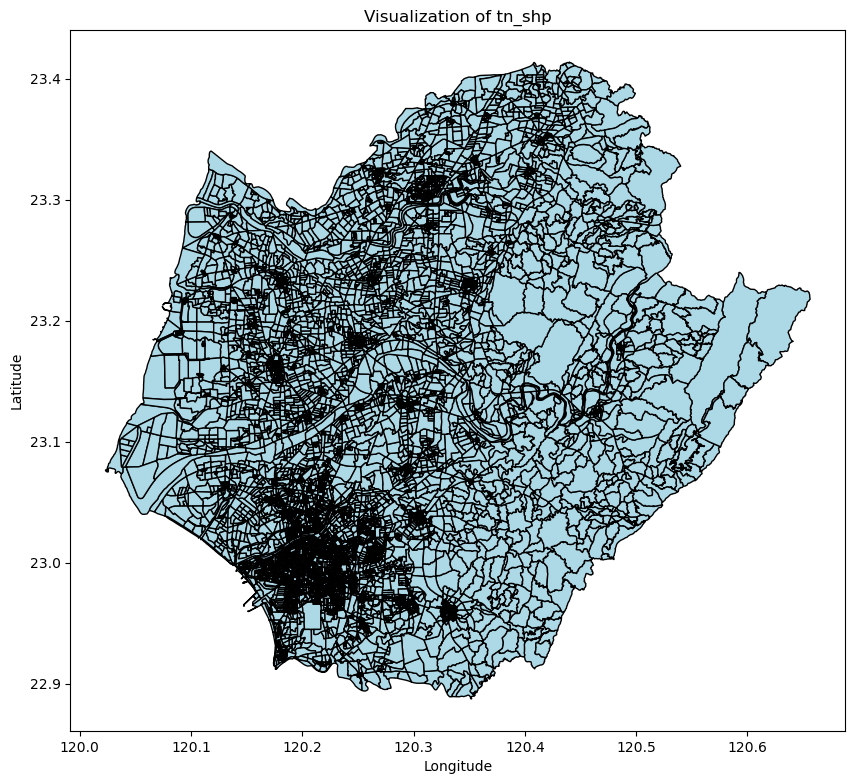

In [4]:
# Read in Tainan shapefile
tn_shp = gpd.read_file('C:/Users/Patrick/Downloads/0-67000/G97_67000_U0200_2015.shp')
tn_shp = tn_shp.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 10))
tn_shp.plot(ax=ax, color='lightblue', edgecolor='black')
plt.title("Visualization of tn_shp")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [5]:
#Transform different EPSG, as SHP files from Taiwanese official sources often use a different projection
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:3826", "EPSG:4326", always_xy=True)
ovitrap[['lon','lat']] = ovitrap.apply(
        lambda row: pd.Series(transformer.transform(row['X'], row['Y'])),
    axis=1)

Inspecting the longtitudal and latitudal distribution of where ovitraps are setup.

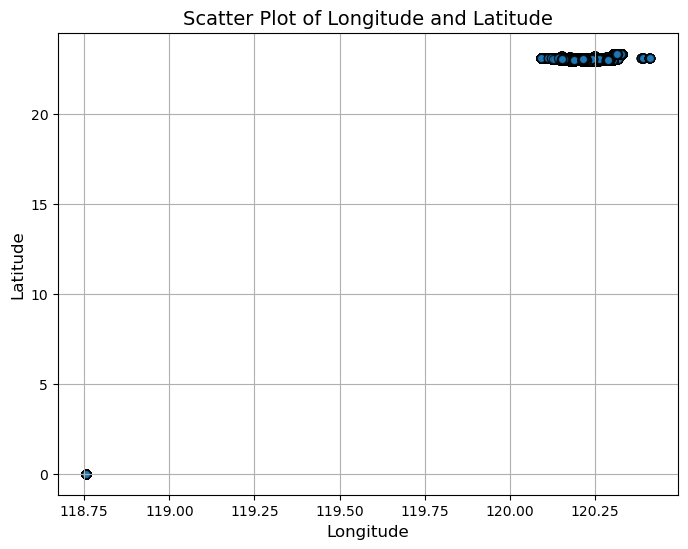

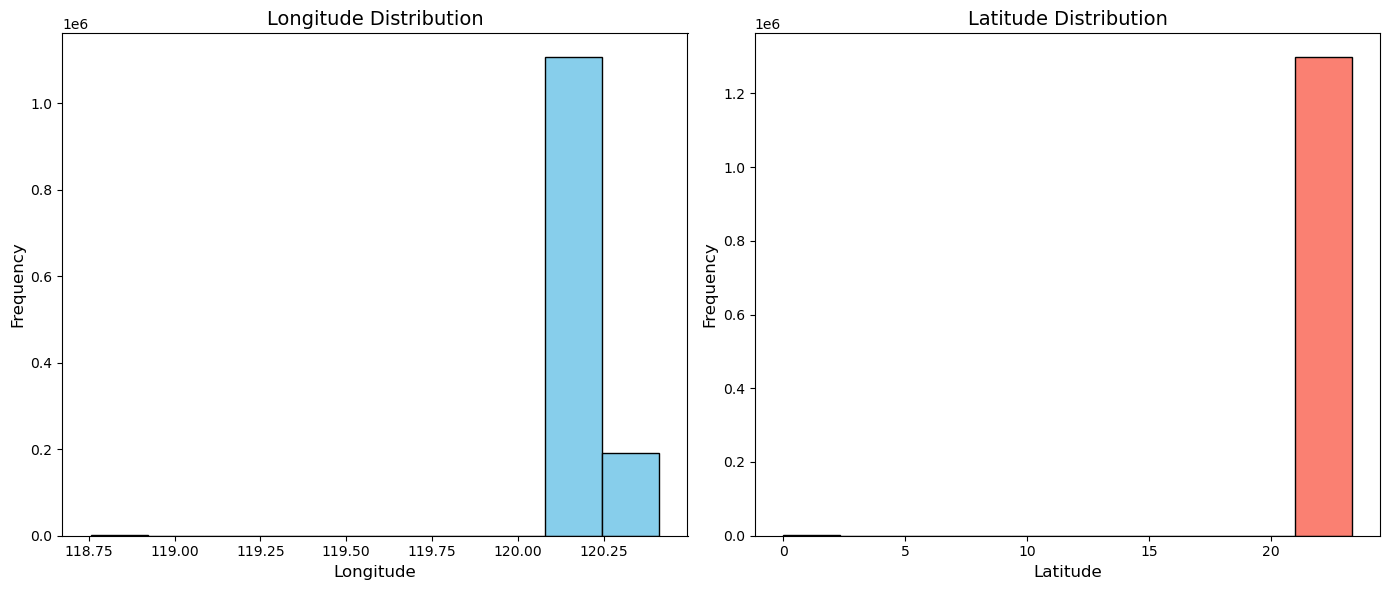

In [6]:
# Scatter Plot of Longitude and Latitude
plt.figure(figsize=(8, 6))
plt.scatter(ovitrap['lon'], ovitrap['lat'], alpha=0.7, edgecolors='k')
plt.title('Scatter Plot of Longitude and Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()

# Histograms for Longitude and Latitude
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Longitude histogram
axes[0].hist(ovitrap['lon'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Longitude Distribution', fontsize=14)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Latitude histogram
axes[1].hist(ovitrap['lat'], bins=10, color='salmon', edgecolor='black')
axes[1].set_title('Latitude Distribution', fontsize=14)
axes[1].set_xlabel('Latitude', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Cleaning the data: Removing outliers
valid_lon = ovitrap['lon'].between(120, 121)
valid_lat = ovitrap['lat'].between(20, 25)
cleaned_ovitrap = ovitrap[valid_lon & valid_lat]

invalid_lon = ~ovitrap['lon'].between(120, 121)
invalid_lat = ~ovitrap['lat'].between(20, 25)

# Outliers DataFrame
outliers = ovitrap[invalid_lon | invalid_lat]

# Error comes from XY being directly longtitude and latitude


Correcting Statistics Outliers for Ovitrap

In [7]:
# Correction for Outliers Data -> Use XY as lon-lat directly
outliers['lon'] = outliers['X']
outliers['lat'] = outliers['Y']

cleaned_ovitrap = pd.concat([cleaned_ovitrap, outliers])

C:\Users\Patrick\AppData\Local\Temp\ipykernel_28504\426182415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['lon'] = outliers['X']
C:\Users\Patrick\AppData\Local\Temp\ipykernel_28504\426182415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['lat'] = outliers['Y']


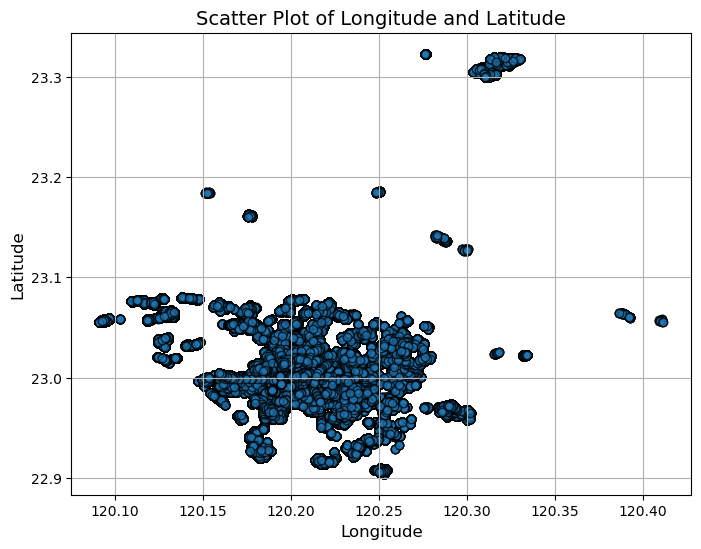

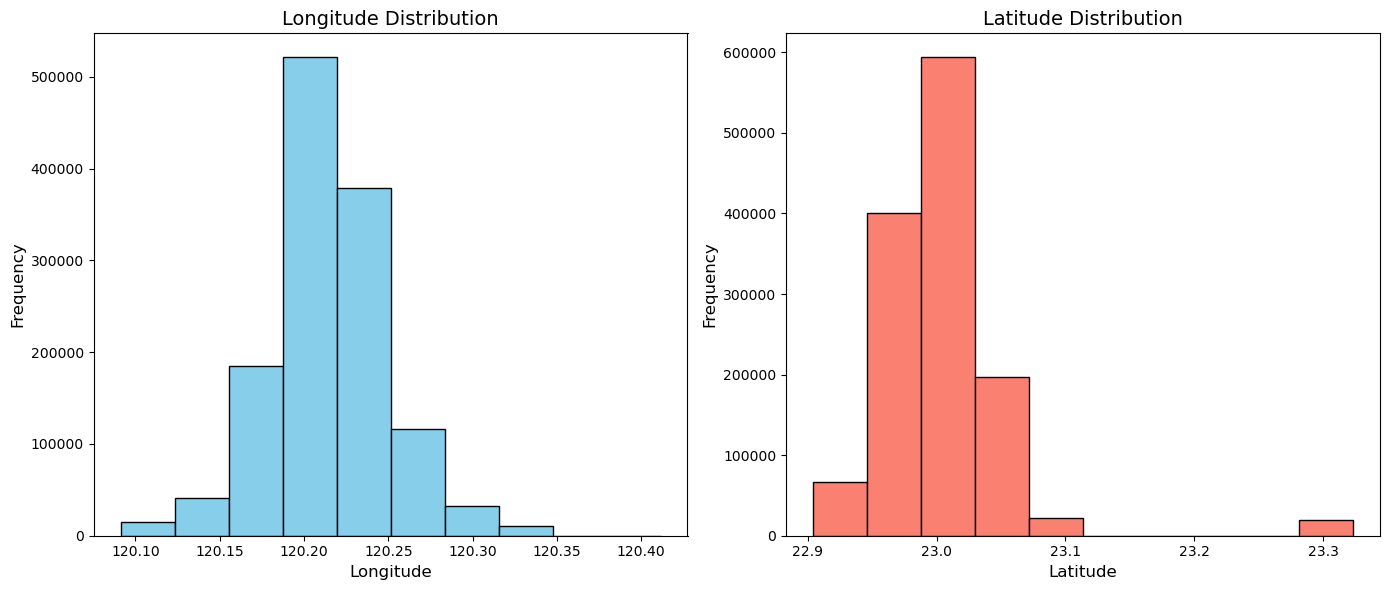

In [8]:
# Scatter Plot of Longitude and Latitude
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_ovitrap['lon'], cleaned_ovitrap['lat'], alpha=0.7, edgecolors='k')
plt.title('Scatter Plot of Longitude and Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()

# Histograms for Longitude and Latitude
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Longitude histogram
axes[0].hist(cleaned_ovitrap['lon'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Longitude Distribution', fontsize=14)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Latitude histogram
axes[1].hist(cleaned_ovitrap['lat'], bins=10, color='salmon', edgecolor='black')
axes[1].set_title('Latitude Distribution', fontsize=14)
axes[1].set_xlabel('Latitude', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

Restrict ovitrap datapoints to the six urban districts of Tainan City.

In [9]:
# Modify ovitrap data and shp file
ovitrap_filtered = cleaned_ovitrap[cleaned_ovitrap['District'].isin(allowed_districts)]
shp_filtered = tn_shp[tn_shp['TOWN'].isin(allowed_districts)]

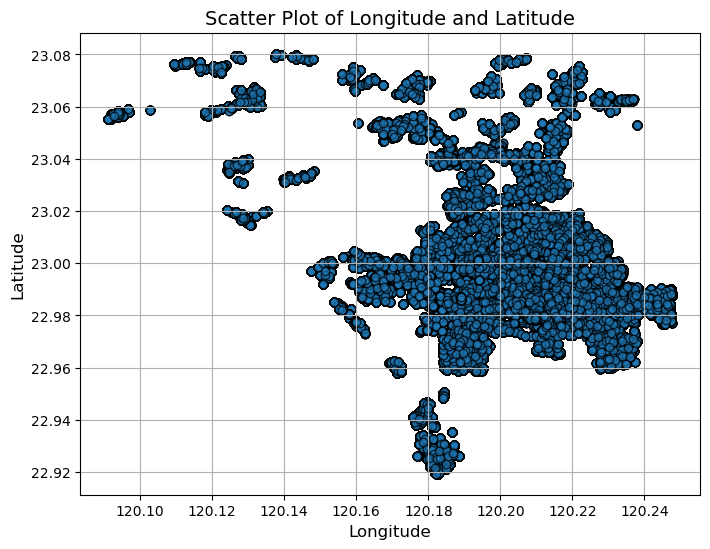

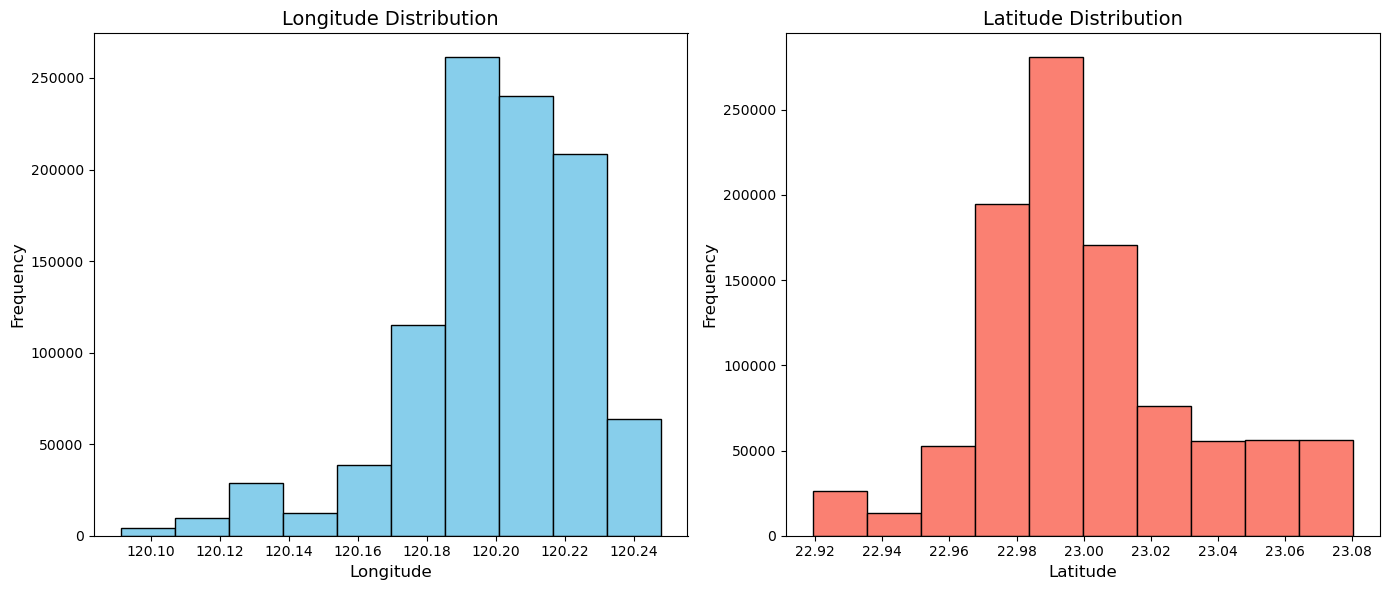

In [10]:
# Scatter Plot of Longitude and Latitude
plt.figure(figsize=(8, 6))
plt.scatter(ovitrap_filtered['lon'], ovitrap_filtered['lat'], alpha=0.7, edgecolors='k')
plt.title('Scatter Plot of Longitude and Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()

# Histograms for Longitude and Latitude
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Longitude histogram
axes[0].hist(ovitrap_filtered['lon'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Longitude Distribution', fontsize=14)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Latitude histogram
axes[1].hist(ovitrap_filtered['lat'], bins=10, color='salmon', edgecolor='black')
axes[1].set_title('Latitude Distribution', fontsize=14)
axes[1].set_xlabel('Latitude', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Cleaning the data: Removing outliers
valid_lon_2 = ovitrap_filtered['lon'].between(120, 121)
valid_lat_2 = ovitrap_filtered['lat'].between(20, 25)
cleaned_ovitrap_2 = ovitrap_filtered[valid_lon_2 & valid_lat_2]

invalid_lon_2 = ~ovitrap_filtered['lon'].between(120, 121)
invalid_lat_2 = ~ovitrap_filtered['lat'].between(20, 25)

# Outliers DataFrame
outliers_2 = ovitrap_filtered[invalid_lon_2 | invalid_lat_2]


Script to create heatmaps based on Ovitrap data.

In [11]:
from shapely.geometry import Point

# Create Point geometries for each event
events_gdf = gpd.GeoDataFrame(
    cleaned_ovitrap_2,
    geometry=gpd.points_from_xy(cleaned_ovitrap_2['lon'], cleaned_ovitrap_2['lat']),
    crs="EPSG:4326"  # Use your coordinate reference system
)

# Check yearly distribution after cleaning
print(events_gdf['Year'].value_counts())

2018    145050
2024    135619
2023    135528
2022    133657
2020    132866
2021    132778
2019    131774
2017     32489
2016      2613
2025       159
Name: Year, dtype: int64


In [19]:
events_gdf

,SerialNo,X,Y,InvestigateUnit,City,District,Village,Address,Outdoor,AddressComment,...,LatestTotalEggs,AvgEggs,TotalBuckets,StartTime,EndTime,Year,Week,lon,lat,geometry
0,20160725901,168197.000000,2.544049e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,永福路二段203號,True,NaN,...,0,0.0,2,2016-08-01,2016/08/07,2016,31,120.202060,22.995876,POINT (120.20206 22.99588)
1,20160725902,168198.000000,2.544083e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,武廟右前方柱子下,True,NaN,...,0,0.0,2,2016-08-01,2016/08/07,2016,31,120.202068,22.996183,POINT (120.20207 22.99618)
2,20160725903,168082.000000,2.544099e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,永福路二段197巷15號,True,NaN,...,46,30.0,2,2016-08-01,2016/08/07,2016,31,120.200936,22.996322,POINT (120.20094 22.99632)
3,20160725904,167967.000000,2.544085e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,西門路二段272號（水果行）,True,NaN,...,0,0.0,2,2016-08-01,2016/08/07,2016,31,120.199815,22.996190,POINT (120.19981 22.99619)
4,20160725905,168017.000000,2.544113e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,西門路二段300巷21號,True,NaN,...,0,4.5,2,2016-08-01,2016/08/07,2016,31,120.200301,22.996445,POINT (120.2003 22.99645)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218531,1701TWMZ902,120.194053,2.299339e+01,台南市衛生局,台南市,中西區,民主里,中正路347號,True,NaN,...,0,0.0,2,2018-12-17,2018/12/23,2018,51,120.194053,22.993390,POINT (120.19405 22.99339)
220672,1647TWXH901,120.193792,2.300121e+01,台南市衛生局,台南市,中西區,協和里,臨安路一段212巷12號,True,NaN,...,0,0.0,2,2018-12-24,2018/12/30,2018,52,120.193792,23.001207,POINT (120.19379 23.00121)
222109,1701TWMZ902,120.194053,2.299339e+01,台南市衛生局,台南市,中西區,民主里,中正路347號,True,NaN,...,0,0.0,2,2018-12-24,2018/12/30,2018,52,120.194053,22.993390,POINT (120.19405 22.99339)
226544,1647TWXH901,120.193792,2.300121e+01,台南市衛生局,台南市,中西區,協和里,臨安路一段212巷12號,True,NaN,...,0,0.0,1,2018-12-31,2019/01/06,2018,1,120.193792,23.001207,POINT (120.19379 23.00121)


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Projects/TMU/Ovitrap_Dengue\\Ovitrap_Locations_2016.png'

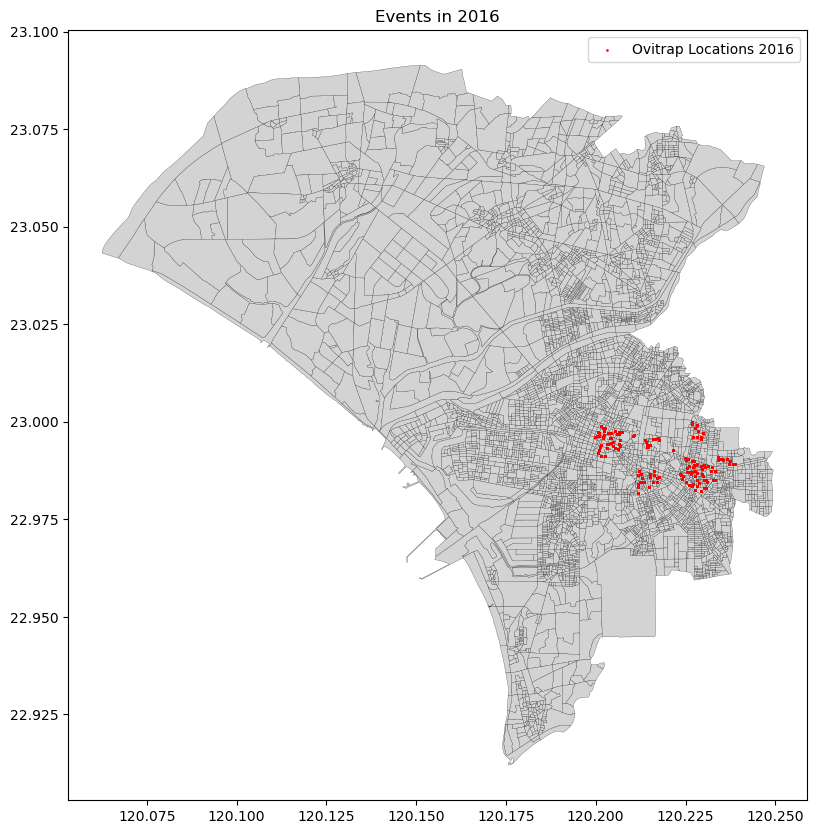

In [13]:
unique_years = events_gdf["Year"].unique()

# Loop through each year and generate a plot
for year in unique_years:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the shapefile
    shp_filtered.plot(ax=ax, color="lightgrey", edgecolor="Black", linewidth = 0.15)
    
    # Plot the events for that year
    events_gdf[events_gdf["Year"] == year].plot(ax=ax, color="red", markersize=0.75, label=f"Ovitrap Locations {year}")
    
    # Formatting
    ax.set_title(f"Events in {year}")
    ax.legend()
    
    # Define file path
    file_path = os.path.join(save_dir, f'Ovitrap_Locations_{year}.png')
    
    # Save figure before showing
    plt.savefig(file_path)  
    plt.close()  # Close to free memory

In [21]:
# Ensure both GeoDataFrames have the same CRS
segments_gdf = shp_filtered.to_crs(events_gdf.crs)

# Spatial join: Assign each event to a segment
joined_gdf = gpd.sjoin(events_gdf, segments_gdf, how="inner", predicate="intersects")

# Aggregate event counts by segment and year
aggregated_counts = joined_gdf.groupby(['Year', 'index_right'])['AvgEggs'].sum().reset_index()

# Merge aggregated counts back with the segments shapefile
segments_gdf['index'] = segments_gdf.index  # Ensure a matching key
heatmap_data = segments_gdf.merge(aggregated_counts, left_on='index', right_on='index_right', how='left')

# Fill NaN counts with 0 for areas with no events in a given year
heatmap_data['AvgEggs'] = heatmap_data['AvgEggs'].fillna(0)


In [23]:
heatmap_data

,U_ID,CODEBASE,CODE1,CODE2,TOWN_ID,TOWN,COUNTY_ID,COUNTY,X,Y,AREA,geometry,index,Year,index_right,AvgEggs
0,5144,A6733-0874-00,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166173.68829,2.535589e+06,25735.24733,"POLYGON Z ((120.18422 22.92033 0, 120.1842 22....",1485,2017.0,1485.0,0.00
1,5144,A6733-0874-00,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166173.68829,2.535589e+06,25735.24733,"POLYGON Z ((120.18422 22.92033 0, 120.1842 22....",1485,2018.0,1485.0,658.83
2,5144,A6733-0874-00,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166173.68829,2.535589e+06,25735.24733,"POLYGON Z ((120.18422 22.92033 0, 120.1842 22....",1485,2019.0,1485.0,416.00
3,5144,A6733-0874-00,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166173.68829,2.535589e+06,25735.24733,"POLYGON Z ((120.18422 22.92033 0, 120.1842 22....",1485,2020.0,1485.0,871.00
4,5144,A6733-0874-00,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166173.68829,2.535589e+06,25735.24733,"POLYGON Z ((120.18422 22.92033 0, 120.1842 22....",1485,2021.0,1485.0,847.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18495,780,A6735-0759-00,A6735-26-005,A6735-26,67000350,安南區,67000,臺南市,167484.42419,2.549441e+06,7543.19820,"POLYGON Z ((120.19443 23.04494 0, 120.19545 23...",7931,2023.0,7931.0,123.50
18496,780,A6735-0759-00,A6735-26-005,A6735-26,67000350,安南區,67000,臺南市,167484.42419,2.549441e+06,7543.19820,"POLYGON Z ((120.19443 23.04494 0, 120.19545 23...",7931,2024.0,7931.0,49.00
18497,781,A6735-0769-00,A6735-30-005,A6735-30,67000350,安南區,67000,臺南市,166722.60054,2.549380e+06,14166.79920,"POLYGON Z ((120.18819 23.04477 0, 120.18805 23...",7932,NaN,NaN,0.00
18498,782,A6735-0771-00,A6735-31-003,A6735-31,67000350,安南區,67000,臺南市,170398.40330,2.549387e+06,13984.25205,"POLYGON Z ((120.22266 23.04487 0, 120.22421 23...",7933,NaN,NaN,0.00


In [18]:
tn_shp

,U_ID,CODEBASE,CODE1,CODE2,TOWN_ID,TOWN,COUNTY_ID,COUNTY,X,Y,AREA,geometry
0,1519,A6713-0044-00,A6713-03-004,A6713-03,67000130,學甲區,67000,臺南市,167095.16348,2.573509e+06,2.409279e+06,"POLYGON Z ((120.17383 23.2717 0, 120.17414 23...."
1,1520,A6706-0169-00,A6706-10-004,A6706-10,67000060,東山區,67000,臺南市,195790.88048,2.574560e+06,1.871302e+05,"POLYGON Z ((120.46841 23.27525 0, 120.46847 23..."
2,1521,A6704-0124-00,A6704-07-007,A6704-07,67000040,柳營區,67000,臺南市,178154.64243,2.574746e+06,5.917852e+04,"POLYGON Z ((120.29947 23.27444 0, 120.29947 23..."
3,1522,A6701-0425-00,A6701-27-006,A6701-27,67000010,新營區,67000,臺南市,175860.08597,2.574747e+06,2.694759e+04,"POLYGON Z ((120.27531 23.27419 0, 120.27567 23..."
4,1593,A6706-0182-00,A6706-10-005,A6706-10,67000060,東山區,67000,臺南市,195370.86654,2.573953e+06,1.849167e+05,"POLYGON Z ((120.4688 23.26962 0, 120.46887 23...."
...,...,...,...,...,...,...,...,...,...,...,...,...
12769,3108,A6710-0138-00,A6710-07-004,A6710-07,67000100,官田區,67000,臺南市,179864.54916,2.564638e+06,4.500631e+05,"POLYGON Z ((120.31738 23.1852 0, 120.31813 23...."
12770,3109,A6707-0157-00,A6707-05-006,A6707-05,67000070,麻豆區,67000,臺南市,173376.00015,2.564946e+06,1.006336e+04,"POLYGON Z ((120.25085 23.18521 0, 120.25103 23..."
12771,3110,A6707-0163-00,A6707-05-007,A6707-05,67000070,麻豆區,67000,臺南市,173493.29866,2.564901e+06,2.001176e+04,"POLYGON Z ((120.2524 23.18523 0, 120.25242 23...."
12772,3111,A6707-0164-00,A6707-05-008,A6707-05,67000070,麻豆區,67000,臺南市,173594.45705,2.564904e+06,1.244706e+04,"POLYGON Z ((120.25325 23.18522 0, 120.25395 23..."


In [ ]:
# Define years to plot 
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Create a DataFrame with all combinations of years and segments
all_segments = pd.DataFrame({
    'Year': [year for year in years for _ in range(len(segments_gdf))],
    'index': [index for _ in years for index in segments_gdf.index]
})

# Ensure geometry is correctly managed
segments_gdf = segments_gdf.reset_index()  # Reset index to ensure clean merging

# Merge with the shapefile to ensure all segments are included for each year
full_template = pd.merge(
    all_segments,
    segments_gdf[['index', 'geometry']],  # Select only required columns
    on='index',
    how='left'
)

# Merge with aggregated data to fill in missing combinations with NaN
heatmap_data_full = pd.merge(
    full_template,
    heatmap_data,
    on=['Year', 'index'],
    how='left'
)

# Fill missing values for AvgEggs with 0
heatmap_data_full['AvgEggs'] = heatmap_data_full['AvgEggs'].fillna(0)

# Drop any duplicate or conflicting geometry columns
if 'geometry_x' in heatmap_data_full.columns or 'geometry_y' in heatmap_data_full.columns:
    heatmap_data_full['geometry'] = heatmap_data_full['geometry_x'].combine_first(heatmap_data_full['geometry_y'])
    heatmap_data_full = heatmap_data_full.drop(columns=['geometry_x', 'geometry_y'])

# Convert to GeoDataFrame for plotting
full_gdf = gpd.GeoDataFrame(heatmap_data_full, geometry='geometry', crs=segments_gdf.crs)


In [ ]:
# Plotting heatmaps
for year in years:
    # Filter data for the current year
    year_data = full_gdf[full_gdf['Year'] == year]
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the shapefile with counts as a heatmap
    year_data.plot(
        column='AvgEggs',       # The column to color by (event counts)
        cmap='OrRd',           # Color map for the heatmap
        legend=True,           # Show a legend
        ax=ax,
        edgecolor=None,        # Remove borders
        missing_kwds={
            "color": "lightgray",  # Set the color for missing values
            "label": "No data"     # Add a label for missing data in the legend
        }
    )
    
    # Customize plot
    ax.set_title(f"Aggregated AvgEggs in each BSA in {year}")
    ax.set_axis_off()  # Remove axis for better visual appeal
    
    # Save the heatmap
    save_path = os.path.join(save_dir, f"heatmap_{year}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory
    
    print(f"Heatmap for {year} saved to {save_path}")


Heatmap for 2015 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2015.png
Heatmap for 2016 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2016.png
Heatmap for 2017 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2017.png
Heatmap for 2018 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2018.png
Heatmap for 2019 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2019.png
Heatmap for 2020 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2020.png
Heatmap for 2021 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2021.png
Heatmap for 2022 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2022.png
Heatmap for 2023 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2023.png
Heatmap for 2024 saved to D:/Projects/TMU/Ovitrap_Dengue\heatmap_2024.png


Script to create time series plot for weekly aggregated AvgEggs.

In [ ]:
# Group by year and week, and sum AvgEggs
weekly_aggregated = ovitrap_filtered.groupby(['Year', 'Week'])['AvgEggs'].sum().reset_index()

# Generate individual plots for each year
unique_years = weekly_aggregated['Year'].unique()

for year in unique_years:
    yearly_data = weekly_aggregated[weekly_aggregated['Year'] == year]
    
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_data['Week'], yearly_data['AvgEggs'], marker='o')
    
    plt.title(f'Weekly Aggregated AvgEggs Counts - Year {year}')
    plt.xlabel('Week Number')
    plt.ylabel('Aggregated AvgEggs Count')
    plt.grid(True)
    
    # Save the plot
    file_path = os.path.join(save_dir, f'weekly_avg_eggs_{year}.png')
    plt.savefig(file_path)
    plt.close()  # Close the plot to free up memory

In [ ]:
# Plotting a version where Weekly AvgEggs curves are overlayed atop each other
plt.figure(figsize=(12, 6))

for year in weekly_aggregated['Year'].unique():
    yearly_data = weekly_aggregated[weekly_aggregated['Year'] == year]
    plt.plot(yearly_data['Week'], yearly_data['AvgEggs'], label=f'Year {year}')

plt.title('Weekly Aggregated AvgEggs Counts All Years')
plt.xlabel('Week Number')
plt.ylabel('Aggregated AvgEggs Count')
plt.legend()
plt.grid(True)
file_path = os.path.join(save_dir, f'weekly_avgs_eggs_all.png')
plt.savefig(file_path)
plt.close()  # Close the plot to free up memory

Script to create whole year aggregated egg counts.

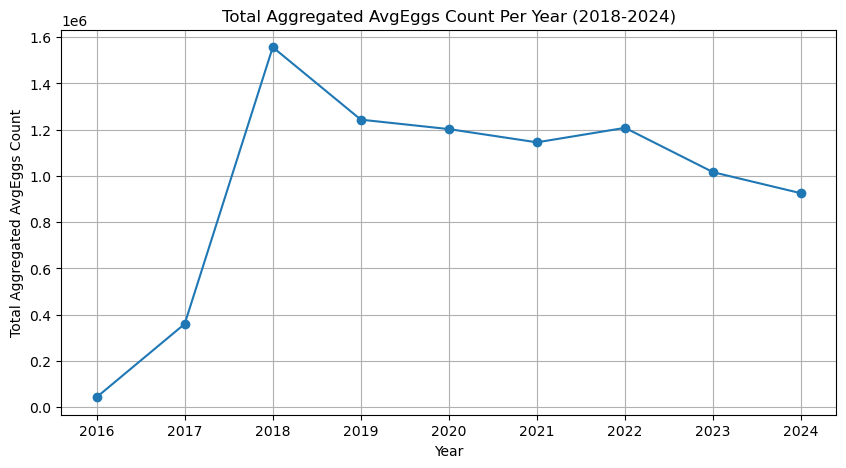

In [ ]:
# Aggregate the total AvgEggs count per year
yearly_aggregated = ovitrap_filtered.groupby('Year')['AvgEggs'].sum().reset_index()

# Filter data for the range 2018-2024
yearly_aggregated = yearly_aggregated[(yearly_aggregated['Year'] >= 2016) & (yearly_aggregated['Year'] <= 2024)]

# Plot the yearly trend
plt.figure(figsize=(10, 5))
plt.plot(yearly_aggregated['Year'], yearly_aggregated['AvgEggs'], marker='o', linestyle='-')

plt.title('Total Aggregated AvgEggs Count Per Year (2018-2024)')
plt.xlabel('Year')
plt.ylabel('Total Aggregated AvgEggs Count')
plt.grid(True)

# Save the plot
file_path = os.path.join(save_dir, 'yearly_avg_eggs_2018_2024.png')
plt.savefig(file_path)
plt.show()  # Show the plot


Plot saved to D:/Projects/TMU/Ovitrap_Dengue\weekly_entries.png


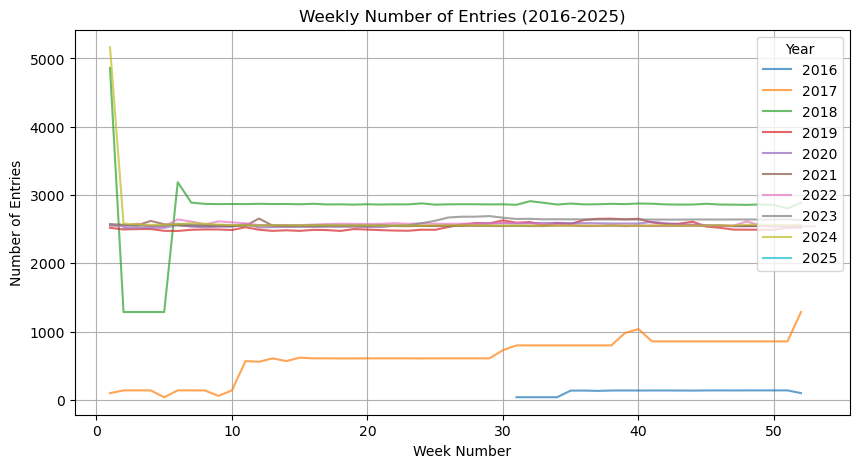

In [ ]:
# Group by Year and Week to count entries
weekly_counts = ovitrap_filtered.groupby(['Year', 'Week']).size().unstack(level=0)

# Plot each year's weekly data
plt.figure(figsize=(10, 5))
for year in weekly_counts.columns:
    plt.plot(weekly_counts.index, weekly_counts[year], label=year, alpha=0.7)

plt.xlabel("Week Number")
plt.ylabel("Number of Entries")
plt.title("Weekly Number of Entries (2016-2025)")
plt.legend(title="Year")
plt.grid(True)

# Save plot instead of showing
  # Change this to your desired directory
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
save_path = os.path.join(save_dir, "weekly_entries.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"Plot saved to {save_path}")


As 2016 and 2017 have way less base ovitraps set up, we exclude these two years from subsequent plotting.

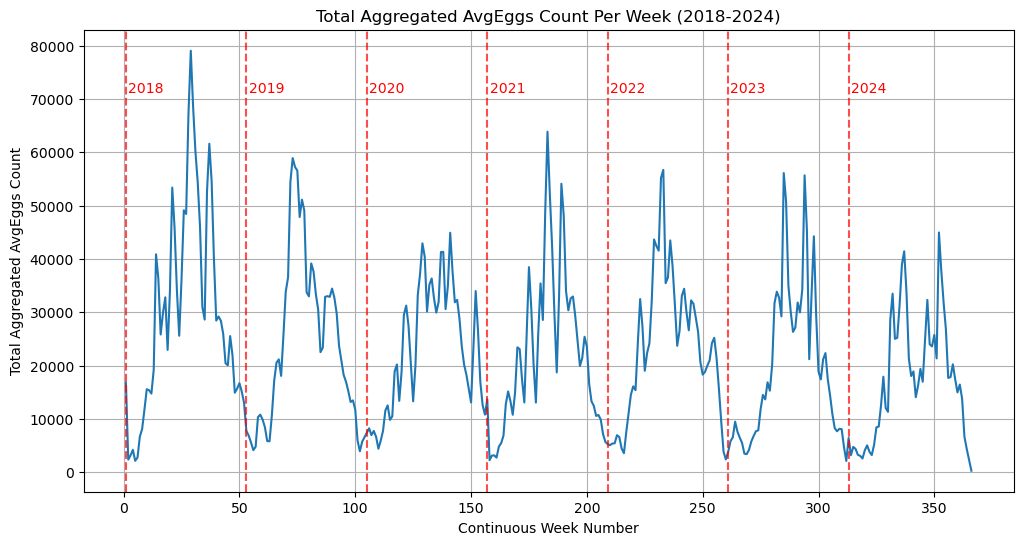

In [ ]:
# Now we create a version that shows weekly aggregated but chains together all years between 2018 and 2025.
# Filter data to include only 2018 onwards (without modifying original data)
plot_data = ovitrap_filtered[ovitrap_filtered['Year'] >= 2018].copy()

# Create a continuous week index for plotting
plot_data['Continuous_Week'] = (plot_data['Year'] - 2018) * 52 + plot_data['Week']

# Aggregate data by continuous week index
weekly_aggregated = (
    plot_data
    .groupby('Continuous_Week')['AvgEggs']
    .sum()
    .reset_index()
)

# Define year transition points
year_start_weeks = {year: (year - 2018) * 52 + 1 for year in range(2018, 2025)}

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(weekly_aggregated['Continuous_Week'], weekly_aggregated['AvgEggs'], marker=None, linestyle='-')

# Add vertical lines for year boundaries
for year, week in year_start_weeks.items():
    plt.axvline(x=week, color='red', linestyle='--', alpha=0.7)
    plt.text(week + 1, weekly_aggregated['AvgEggs'].max() * 0.9, str(year), color='red', fontsize=10)

plt.title('Total Aggregated AvgEggs Count Per Week (2018-2024)')
plt.xlabel('Continuous Week Number')
plt.ylabel('Total Aggregated AvgEggs Count')
plt.grid(True)

# Save the plot
file_path = os.path.join(save_dir, 'weekly_avg_eggs_2018_2024.png')
plt.savefig(file_path)
plt.show()  # Show the plot


This section performs IDW interpolation, comment out to use.

In [ ]:
# import os
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from scipy.spatial import distance_matrix
# from rasterio.mask import mask
# import rasterio
# from rasterio.transform import from_origin

# # Function to perform IDW interpolation
# # Process data in chunks to avoid memory issues
# def idw_interpolation(coords, values, grid_x, grid_y, power=2, chunk_size=50):
#     grid_shape = grid_x.shape
#     grid_points = np.column_stack([grid_x.flatten(), grid_y.flatten()])
#     idw_values = np.zeros(grid_points.shape[0])

#     # Process grid points in smaller chunks
#     for i in range(0, len(grid_points), chunk_size):
#         chunk = grid_points[i:i + chunk_size]
#         dist_matrix = distance_matrix(coords, chunk)

#         # Avoid division by zero by setting zero distances to a very small value
#         dist_matrix[dist_matrix == 0] = 1e-10

#         weights = 1 / (dist_matrix ** power)
#         weights_sum = weights.sum(axis=0)

#         # Normalize weights and compute IDW
#         normalized_weights = weights / weights_sum
#         idw_values[i:i + chunk_size] = np.dot(normalized_weights.T, values)

#     return idw_values.reshape(grid_shape)



# # Ensure coordinate systems match
# shp_filtered = shp_filtered.to_crs("EPSG:4326")
# events_gdf = events_gdf.to_crs("EPSG:4326")

# # Set the year range
# years = list(range(2015, 2025))

# # Grid resolution (adjust as needed)
# grid_resolution = 500  # Number of grid cells per dimension

# # Iterate over the years
# for year in years:
#     print(f"Processing year {year}...")

#     # Filter events for the specific year
#     filtered_events = events_gdf[events_gdf['year'] == year]

#     if filtered_events.empty:
#         print(f"No data available for year {year}. Skipping.")
#         continue

#     # Generate a grid of points within the bounds of the filtered shapefile
#     minx, miny, maxx, maxy = shp_filtered.total_bounds
#     grid_x, grid_y = np.meshgrid(np.linspace(minx, maxx, grid_resolution),
#                                  np.linspace(miny, maxy, grid_resolution))

#     # Extract the coordinates and values
#     coords = np.array(list(zip(filtered_events['lon'], filtered_events['lat'])))
#     values = filtered_events['AvgEggs'].values

#     # Perform IDW interpolation
#     idw_values = idw_interpolation(coords, values, grid_x, grid_y)

#     # Create a raster for the IDW surface
#     transform = from_origin(minx, maxy, (maxx - minx) / grid_resolution, (maxy - miny) / grid_resolution)
#     raster_path = os.path.join(save_dir, f"idw_{year}.tif")

#     with rasterio.open(raster_path, 'w', driver='GTiff', count=1, dtype='float32',
#                        crs=shp_filtered.crs.to_string(), transform=transform,
#                        width=grid_x.shape[1], height=grid_x.shape[0]) as dst:
#         dst.write(idw_values.astype('float32'), 1)

#     # Mask the IDW raster using the shapefile
#     with rasterio.open(raster_path) as src:
#         out_image, out_transform = mask(src, shp_filtered.geometry, crop=True)

#     # Save the masked raster
#     masked_raster_path = os.path.join(save_dir, f"idw_{year}_masked.tif")
#     with rasterio.open(masked_raster_path, 'w', driver='GTiff', count=1, dtype='float32',
#                        crs=shp_filtered.crs.to_string(), transform=out_transform,
#                        width=out_image.shape[2], height=out_image.shape[1]) as dst:
#         dst.write(out_image[0], 1)

#     # Plot the result
#     plot_path = os.path.join(save_dir, f"idw_{year}.png")
#     plt.figure(figsize=(10, 8))
#     plt.imshow(out_image[0], cmap='viridis', extent=[minx, maxx, miny, maxy])
#     plt.colorbar(label='Average Eggs Count')

#     # Plot the filtered shapefile boundary
#     shp_filtered.plot(ax=plt.gca(), facecolor='none', edgecolor='none')

#     plt.title(f'Mosquito Egg Distribution (IDW) in Tainan City - {year}')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')

#     # Save the plot as a PNG file
#     plt.savefig(plot_path, dpi=300)
#     plt.close()

#     print(f"Outputs saved for year {year} in {save_dir}")

# print("Processing complete.")


This section performs kriging, comment out to run.

In [ ]:
# import os
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from pykrige.ok import OrdinaryKriging
# from rasterio.transform import from_origin
# from rasterio.mask import mask
# import rasterio

# # Function to perform Kriging interpolation in chunks
# def kriging_interpolation(coords, values, grid_x, grid_y, variogram_model="linear"):
#     grid_shape = grid_x.shape

#     # Set up Kriging
#     krige = OrdinaryKriging(
#         coords[:, 0], coords[:, 1], values,
#         variogram_model=variogram_model,
#         verbose=False, enable_plotting=False
#     )

#     # Perform Kriging
#     z, ss = krige.execute("grid", grid_x[0], grid_y[:, 0])
#     return z

# # Set the year range
# years = list(range(2015, 2025))

# # Grid resolution (adjust as needed)
# grid_resolution = 70

# # Iterate over the years
# for year in years:
#     print(f"Processing year {year}...")

#     # Filter events for the specific year
#     filtered_events = events_gdf[events_gdf['year'] == year]

#     if filtered_events.empty:
#         print(f"No data available for year {year}. Skipping.")
#         continue

#     # Generate a grid of points within the bounds of the filtered shapefile
#     minx, miny, maxx, maxy = shp_filtered.total_bounds
#     grid_x, grid_y = np.meshgrid(np.linspace(minx, maxx, grid_resolution),
#                                  np.linspace(miny, maxy, grid_resolution))

#     # Extract the coordinates and values
#     coords = np.array(list(zip(filtered_events['lon'], filtered_events['lat'])))
#     values = filtered_events['AvgEggs'].values

#     # Perform Kriging interpolation
#     kriging_values = kriging_interpolation(coords, values, grid_x, grid_y)

#     # Create a raster for the Kriging surface
#     transform = from_origin(minx, maxy, (maxx - minx) / grid_resolution, (maxy - miny) / grid_resolution)
#     raster_path = os.path.join(save_dir, f"kriging_{year}.tif")

#     with rasterio.open(raster_path, 'w', driver='GTiff', count=1, dtype='float32',
#                        crs=shp_filtered.crs.to_string(), transform=transform,
#                        width=grid_x.shape[1], height=grid_x.shape[0]) as dst:
#         dst.write(kriging_values.astype('float32'), 1)

#     # Mask the Kriging raster using the shapefile
#     with rasterio.open(raster_path) as src:
#         out_image, out_transform = mask(src, shp_filtered.geometry, crop=True)

#     # Save the masked raster
#     masked_raster_path = os.path.join(save_dir, f"kriging_{year}_masked.tif")
#     with rasterio.open(masked_raster_path, 'w', driver='GTiff', count=1, dtype='float32',
#                        crs=shp_filtered.crs.to_string(), transform=out_transform,
#                        width=out_image.shape[2], height=out_image.shape[1]) as dst:
#         dst.write(out_image[0], 1)

#     # Plot the result
#     plot_path = os.path.join(save_dir, f"kriging_{year}.png")
#     plt.figure(figsize=(10, 8))
#     plt.imshow(out_image[0], cmap='viridis', extent=[minx, maxx, miny, maxy])
#     plt.colorbar(label='Average Eggs Count')

#     # Plot the filtered shapefile boundary
#     shp_filtered.plot(ax=plt.gca(), facecolor='none', edgecolor='black', linewidth=1)

#     plt.title(f'Mosquito Egg Distribution (Kriging) in Tainan City - {year}')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')

#     # Save the plot as a PNG file
#     plt.savefig(plot_path, dpi=300)
#     plt.close()

#     print(f"Outputs saved for year {year} in {save_dir}")

# print("Processing complete.")


Inpsecting Dengue Fever Infection Data.

In [ ]:
'''Import CSV Files of Basic Statistics Area and their Population'''

# Directory containing the nested folders
BSA_dir = "D:/Projects/TMU/BSA_population_TN"

# Walk through the directory to find all CSV files
for root, dirs, files in os.walk(BSA_dir):
    for file in files:
        if file.endswith(".csv"):
            # Extract the first number from the filename
            number = int(''.join(filter(str.isdigit, file.split("年")[0])))  # Get the number before '年'
            year = number + 1911  # Add 1911
            
            # Full path to the CSV file
            file_path = os.path.join(root, file)
            
            # Attempt to load the CSV file with both encodings
            for encoding in ["utf-8", "big5"]:
                try:
                    df_name = f"df_{year}"
                    globals()[df_name] = pd.read_csv(file_path, encoding=encoding)
                    print(f"Successfully loaded {file} as {df_name} using {encoding} encoding.")
                    break  # Exit the loop if successfully loaded
                except Exception as e:
                    print(f"Failed to load {file} with {encoding} encoding. Error: {e}")

Failed to load 104年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 104年12月臺南市統計區人口統計_最小統計區.csv as df_2015 using big5 encoding.
Failed to load 105年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 105年12月臺南市統計區人口統計_最小統計區.csv as df_2016 using big5 encoding.
Successfully loaded 106年12月臺南市統計區人口統計_最小統計區.csv as df_2017 using utf-8 encoding.
Failed to load 107年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 107年12月臺南市統計區人口統計_最小統計區.csv as df_2018 using big5 encoding.
Failed to load 108年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 108年12月臺南市統計區人口統計_最小統計區.csv as df_2019 using big5 encoding.
Failed to load 109年12月臺南市統計區人口統

In [ ]:
# Filter Dengue Cases by Tainan
dengue_local = dengue[dengue['是否境外移入']=='否'].reset_index(drop=True)
tn_dengue = dengue_local[dengue_local['居住縣市']=='台南市'].reset_index(drop=True)
urban_tn_dengue = tn_dengue[
    (tn_dengue['居住鄉鎮'].isin(allowed_districts)) &
    (tn_dengue['Year'] >= 2015) &
    (tn_dengue['Year'] <= 2023) ].reset_index(drop=True)
print(urban_tn_dengue.shape)

(34134, 28)


Creating heatmaps of dengue fever infection for the three highest years.

In [ ]:
# Tallying dengue infections by year and CODEBASE
dengue_2015 = urban_tn_dengue[urban_tn_dengue['Year'] == 2015].groupby('CODEBASE').size().reset_index(name='Infections_2015')
dengue_2019 = urban_tn_dengue[urban_tn_dengue['Year'] == 2019].groupby('CODEBASE').size().reset_index(name='Infections_2019')
dengue_2023 = urban_tn_dengue[urban_tn_dengue['Year'] == 2023].groupby('CODEBASE').size().reset_index(name='Infections_2023')

# Merging population data with infection counts for each year
df_2015_pop = df_2015[['CODEBASE', 'P_CNT']].rename(columns={'P_CNT': 'Population_2015'})
df_2019_pop = df_2019[['CODEBASE', 'P_CNT']].rename(columns={'P_CNT': 'Population_2019'})
df_2023_pop = df_2023[['CODEBASE', 'P_CNT']].rename(columns={'P_CNT': 'Population_2023'})

# Merging infection data with population data for each year
df_2015_incidence = pd.merge(dengue_2015, df_2015_pop, on='CODEBASE', how='left')
df_2019_incidence = pd.merge(dengue_2019, df_2019_pop, on='CODEBASE', how='left')
df_2023_incidence = pd.merge(dengue_2023, df_2023_pop, on='CODEBASE', how='left')


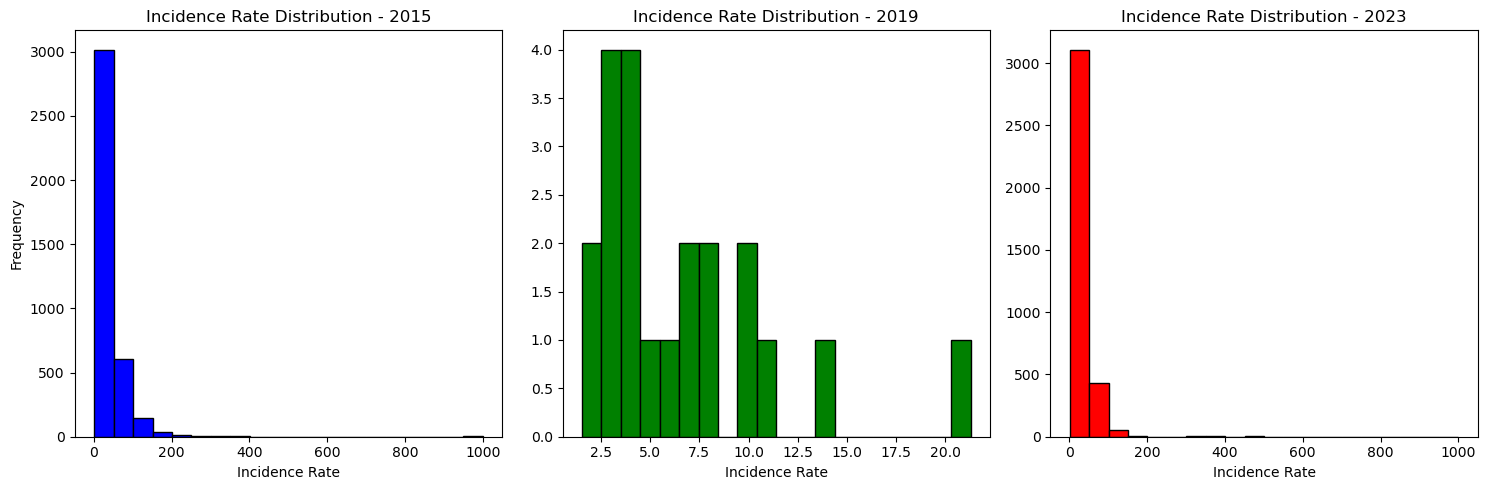

In [ ]:
# Ensure all infection and population columns are numeric
df_2015_incidence['Infections_2015'] = pd.to_numeric(df_2015_incidence['Infections_2015'], errors='coerce')
df_2015_incidence['Population_2015'] = pd.to_numeric(df_2015_incidence['Population_2015'], errors='coerce')

df_2019_incidence['Infections_2019'] = pd.to_numeric(df_2019_incidence['Infections_2019'], errors='coerce')
df_2019_incidence['Population_2019'] = pd.to_numeric(df_2019_incidence['Population_2019'], errors='coerce')

df_2023_incidence['Infections_2023'] = pd.to_numeric(df_2023_incidence['Infections_2023'], errors='coerce')
df_2023_incidence['Population_2023'] = pd.to_numeric(df_2023_incidence['Population_2023'], errors='coerce')

# Now calculate the incidence rates
df_2015_incidence['Incidence_Rate_2015'] = (df_2015_incidence['Infections_2015'] / df_2015_incidence['Population_2015']) * 1000
df_2019_incidence['Incidence_Rate_2019'] = (df_2019_incidence['Infections_2019'] / df_2019_incidence['Population_2019']) * 1000
df_2023_incidence['Incidence_Rate_2023'] = (df_2023_incidence['Infections_2023'] / df_2023_incidence['Population_2023']) * 1000

high_incidence_2015 = df_2015_incidence[df_2015_incidence['Incidence_Rate_2015'] > 1000]
high_incidence_2019 = df_2019_incidence[df_2019_incidence['Incidence_Rate_2019'] > 1000]
high_incidence_2023 = df_2023_incidence[df_2023_incidence['Incidence_Rate_2023'] > 1000]

# (Optional) Remove high incidence rows from original dataframes
df_2015_incidence = df_2015_incidence[df_2015_incidence['Incidence_Rate_2015'] <= 1000]
df_2019_incidence = df_2019_incidence[df_2019_incidence['Incidence_Rate_2019'] <= 1000]
df_2023_incidence = df_2023_incidence[df_2023_incidence['Incidence_Rate_2023'] <= 1000]

# Create histograms for incidence rate distribution
plt.figure(figsize=(15, 5))

# Histogram for 2015
plt.subplot(1, 3, 1)
plt.hist(df_2015_incidence['Incidence_Rate_2015'], bins=20, color='blue', edgecolor='black')
plt.title('Incidence Rate Distribution - 2015')
plt.xlabel('Incidence Rate')
plt.ylabel('Frequency')

# Histogram for 2019
plt.subplot(1, 3, 2)
plt.hist(df_2019_incidence['Incidence_Rate_2019'], bins=20, color='green', edgecolor='black')
plt.title('Incidence Rate Distribution - 2019')
plt.xlabel('Incidence Rate')

# Histogram for 2023
plt.subplot(1, 3, 3)
plt.hist(df_2023_incidence['Incidence_Rate_2023'], bins=20, color='red', edgecolor='black')
plt.title('Incidence Rate Distribution - 2023')
plt.xlabel('Incidence Rate')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Define years to plot
years_to_plot = [2015, 2019, 2023]

# Define colormap limits
vmin, vmax = 5, 140  # Focus the color gradient on values 

# Dictionary to store merged data for each year
merged_data = {
    2015: pd.merge(shp_filtered, df_2015_incidence[['CODEBASE', 'Incidence_Rate_2015']], on='CODEBASE', how='left').fillna({'Incidence_Rate_2015': 0}),
    2019: pd.merge(shp_filtered, df_2019_incidence[['CODEBASE', 'Incidence_Rate_2019']], on='CODEBASE', how='left').fillna({'Incidence_Rate_2019': 0}),
    2023: pd.merge(shp_filtered, df_2023_incidence[['CODEBASE', 'Incidence_Rate_2023']], on='CODEBASE', how='left').fillna({'Incidence_Rate_2023': 0})
}

# Loop through each year and generate/save the plots
for year in years_to_plot:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    column_name = f"Incidence_Rate_{year}"
    merged_data[year].plot(column=column_name, ax=ax, legend=True,
                           legend_kwds={'label': f"Dengue Incidence Rate (per 1000 people) in {year}",
                                        'orientation': "horizontal"},
                           cmap='Blues', vmin=vmin, vmax=vmax,
                           missing_kwds={'color': 'gray'})
    ax.set_title(f"Dengue Incidence Rate in {year}")
    plt.savefig(f"{save_dir}/dengue_incidence_{year}.png")  # Save the figure to save_dir
    plt.close()  # Close the figure to free memory

In [ ]:
years_to_plot = [2023]

# Function to generate weekly aggregated plot for a given year
def plot_weekly_aggregated_counts(df, year, output_dir):
    df_year = df[df['Year'] == year]
    df_year['Week'] = df_year['發病日'].dt.isocalendar().week
    
    weekly_counts = df_year.groupby('Week').size()
    
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
    plt.title(f'Weekly Dengue Cases - {year}')
    plt.xlabel('Week Number')
    plt.ylabel('Number of Cases')
    plt.grid(True)
    
    output_path = os.path.join(output_dir, f'dengue_weekly_{year}.png')
    plt.savefig(output_path)
    plt.close()
    return output_path

plot_weekly_aggregated_counts(urban_tn_dengue, 2015, save_dir)
plot_weekly_aggregated_counts(urban_tn_dengue, 2019, save_dir)
plot_weekly_aggregated_counts(urban_tn_dengue, 2023, save_dir)


C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\3320036197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Week'] = df_year['發病日'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\3320036197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Week'] = df_year['發病日'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\3320036197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

'D:/Projects/TMU/Ovitrap_Dengue\\dengue_weekly_2023.png'

Focus on 2023 to compare ovitrap data to dengue infection data curves.

In [ ]:
# Define the years to plot
years_to_plot = [2023]

# Generate weekly aggregated ovitrap data
ovitrap_filtered['Week'] = ovitrap_filtered['StartTime'].dt.isocalendar().week
weekly_aggregated = ovitrap_filtered.groupby(['Year', 'Week'])['AvgEggs'].sum().reset_index()

# Function to plot both ovitrap egg counts (log scale) and dengue cases (linear scale)
def plot_combined_weekly_counts(ovitrap_df, dengue_df, year, output_dir):
    # Filter data for the specific year
    ovitrap_yearly = ovitrap_df[ovitrap_df['Year'] == year]
    dengue_yearly = dengue_df[dengue_df['Year'] == year]

    # Extract week numbers
    dengue_yearly['Week'] = dengue_yearly['發病日'].dt.isocalendar().week

    # Aggregate weekly data
    weekly_dengue_counts = dengue_yearly.groupby('Week').size()
    weekly_ovitrap_counts = ovitrap_yearly.groupby('Week')['AvgEggs'].sum()

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot ovitrap egg counts (log scale)
    ax1.plot(weekly_ovitrap_counts.index, weekly_ovitrap_counts.values, marker='o', linestyle='-', color="blue", label="AvgEggs Count (Log)")
    ax1.set_yscale("log")  # Set log scale for egg counts
    ax1.set_xlabel('Week Number')
    ax1.set_ylabel('AvgEggs Count (Log Scale)', color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Create second y-axis for dengue cases
    ax2 = ax1.twinx()
    ax2.plot(weekly_dengue_counts.index, weekly_dengue_counts.values, marker='s', linestyle='--', color="red", label="Dengue Cases")
    ax2.set_ylabel('Dengue Cases (Linear Scale)', color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    # Title and legends
    plt.title(f'Weekly Dengue Cases & AvgEggs Counts (Log) - {year}')
    fig.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f'Logarithmic curves of ovitrap AvgEggs and Dengue infetions{year}.png')
    plt.savefig(output_path)
    plt.close()

    return output_path

# Generate plots for 2015 and 2023
for year in years_to_plot:
    plot_combined_weekly_counts(weekly_aggregated, urban_tn_dengue, year, save_dir)


C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\4102680299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovitrap_filtered['Week'] = ovitrap_filtered['StartTime'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\4102680299.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_yearly['Week'] = dengue_yearly['發病日'].dt.isocalendar().week


In [ ]:
# Define the years to plot
years_to_plot = [2023]

# Generate weekly aggregated ovitrap data
ovitrap_filtered['Week'] = ovitrap_filtered['StartTime'].dt.isocalendar().week
weekly_aggregated = ovitrap_filtered.groupby(['Year', 'Week'])['AvgEggs'].sum().reset_index()

# Function to plot both ovitrap egg counts (log scale) and dengue cases (linear scale) within the defined time frame
def plot_filtered_weekly_counts(ovitrap_df, dengue_df, year, output_dir):
    # Filter data for the specific year
    ovitrap_yearly = ovitrap_df[ovitrap_df['Year'] == year]
    dengue_yearly = dengue_df[dengue_df['Year'] == year]

    # Extract week numbers
    dengue_yearly['Week'] = dengue_yearly['發病日'].dt.isocalendar().week

    # Aggregate weekly data
    weekly_dengue_counts = dengue_yearly.groupby('Week').size()
    weekly_ovitrap_counts = ovitrap_yearly.groupby('Week')['AvgEggs'].sum()

    # Find the first week where new dengue cases appear
    first_case_week = weekly_dengue_counts[weekly_dengue_counts > 0].index.min()

    # Define the valid range (from first case to week 40)
    valid_weeks = range(first_case_week, 41)

    # Filter data to include only valid weeks
    weekly_dengue_counts = weekly_dengue_counts.loc[weekly_dengue_counts.index.isin(valid_weeks)]
    weekly_ovitrap_counts = weekly_ovitrap_counts.loc[weekly_ovitrap_counts.index.isin(valid_weeks)]

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot ovitrap egg counts (log scale)
    ax1.plot(weekly_ovitrap_counts.index, weekly_ovitrap_counts.values, marker='o', linestyle='-', color="blue", label="AvgEggs Count (Log)")
    ax1.set_yscale("log")  # Set log scale for egg counts
    ax1.set_xlabel('Week Number')
    ax1.set_ylabel('AvgEggs Count (Log Scale)', color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Create second y-axis for dengue cases
    ax2 = ax1.twinx()
    ax2.plot(weekly_dengue_counts.index, weekly_dengue_counts.values, marker='s', linestyle='--', color="red", label="Dengue Cases")
    ax2.set_ylabel('Dengue Cases (Linear Scale)', color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    # Title and legends
    plt.title(f'Weekly Dengue Cases & AvgEggs Counts (Log) - {year} (Week {first_case_week} to 40)')
    fig.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f'early weeks dengue and ovitrap curves {year} - Logarithmic.png')
    plt.savefig(output_path)
    plt.close()

    return output_path

# Generate plots
for year in years_to_plot:
    plot_filtered_weekly_counts(weekly_aggregated, urban_tn_dengue, year, save_dir)


C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\3873476054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovitrap_filtered['Week'] = ovitrap_filtered['StartTime'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\3873476054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_yearly['Week'] = dengue_yearly['發病日'].dt.isocalendar().week


In [ ]:
# Define the years to plot
years_to_plot = [2023]

# Generate weekly aggregated ovitrap data
ovitrap_filtered['Week'] = ovitrap_filtered['StartTime'].dt.isocalendar().week
weekly_aggregated = ovitrap_filtered.groupby(['Year', 'Week'])['AvgEggs'].sum().reset_index()

# Function to plot both ovitrap egg counts and dengue cases (both on linear scale)
def plot_filtered_weekly_counts_linear(ovitrap_df, dengue_df, year, output_dir):
    # Filter data for the specific year
    ovitrap_yearly = ovitrap_df[ovitrap_df['Year'] == year]
    dengue_yearly = dengue_df[dengue_df['Year'] == year]

    # Extract week numbers
    dengue_yearly['Week'] = dengue_yearly['發病日'].dt.isocalendar().week

    # Aggregate weekly data
    weekly_dengue_counts = dengue_yearly.groupby('Week').size()
    weekly_ovitrap_counts = ovitrap_yearly.groupby('Week')['AvgEggs'].sum()

    # Find the first week where new dengue cases appear
    first_case_week = weekly_dengue_counts[weekly_dengue_counts > 0].index.min()

    # Define the valid range (from first case to week 40)
    valid_weeks = range(first_case_week, 41)

    # Filter data to include only valid weeks
    weekly_dengue_counts = weekly_dengue_counts.loc[weekly_dengue_counts.index.isin(valid_weeks)]
    weekly_ovitrap_counts = weekly_ovitrap_counts.loc[weekly_ovitrap_counts.index.isin(valid_weeks)]

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot ovitrap egg counts (linear scale)
    ax1.plot(weekly_ovitrap_counts.index, weekly_ovitrap_counts.values, marker='o', linestyle='-', color="blue", label="AvgEggs Count")
    ax1.set_xlabel('Week Number')
    ax1.set_ylabel('AvgEggs Count (Linear Scale)', color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True, linestyle="--", linewidth=0.5)

    # Create second y-axis for dengue cases
    ax2 = ax1.twinx()
    ax2.plot(weekly_dengue_counts.index, weekly_dengue_counts.values, marker='s', linestyle='--', color="red", label="Dengue Cases")
    ax2.set_ylabel('Dengue Cases (Linear Scale)', color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    # Title and legends
    plt.title(f'Weekly Dengue Cases & AvgEggs Counts - {year} (Week {first_case_week} to 40)')
    fig.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f'early weeks dengue and ovitrap curves {year} - Linear.png')
    plt.savefig(output_path)
    plt.close()

    return output_path

# Generate plots 
for year in years_to_plot:
    plot_filtered_weekly_counts_linear(weekly_aggregated, urban_tn_dengue, year, save_dir)


C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\1076489049.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovitrap_filtered['week'] = ovitrap_filtered['StartTime'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\1076489049.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_yearly['Week'] = dengue_yearly['發病日'].dt.isocalendar().week
C:\Users\Patrick\AppData\Local\Temp\ipykernel_14536\1076489049.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot AvgEggs heatmap
year_data = full_gdf[full_gdf['year'] == 2023]
year_data.plot(
    column='AvgEggs', 
    cmap='OrRd', 
    legend=True, 
    ax=ax, 
    alpha=0.6,  # Make it semi-transparent
    edgecolor=None, 
    missing_kwds={"color": "lightgray", "label": "No data"}
)

# Overlay Dengue Incidence Rate
merged_2023.plot(
    column='Incidence_Rate_2023', 
    cmap='viridis', 
    legend=True, 
    ax=ax, 
    alpha=0.6,  # Transparency for overlay
    edgecolor=None, 
    missing_kwds={'color': 'gray'}
)

# Set title
ax.set_title("Aggregated AvgEggs & Dengue Incidence Rate in 2023")

# Remove axis
ax.set_axis_off()

# Save combined heatmap
save_path = os.path.join(save_dir, "combined_heatmap_2023.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Combined heatmap for 2023 saved to {save_path}")


Combined heatmap for 2023 saved to D:/Projects/TMU/Ovitrap\combined_heatmap_2023.png


ValueError: Invalid RGBA argument: 0.9098039215686274

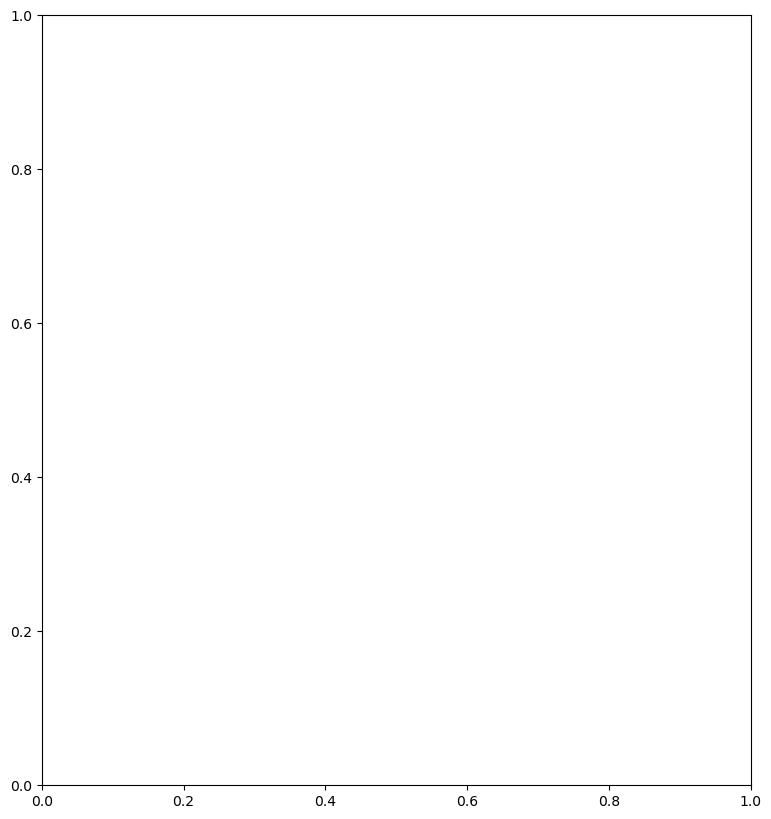

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import matplotlib.colors as mcolors

# Reproject data to EPSG:4326
full_gdf_4326 = full_gdf.to_crs(epsg=4326)
merged_2023_4326 = merged_2023.to_crs(epsg=4326)

# Extract relevant year data
year_data = full_gdf_4326[full_gdf_4326['Year'] == 2023]

# Drop NaN values before processing
year_data = year_data.dropna(subset=["AvgEggs"])
merged_2023_4326 = merged_2023_4326.dropna(subset=["Incidence_Rate_2023"])

# Add small random noise to prevent duplicate bin edges
year_data["AvgEggs_adj"] = year_data["AvgEggs"].fillna(year_data["AvgEggs"].median()) + np.random.uniform(0, 0.0001, size=len(year_data))
merged_2023_4326["Incidence_adj"] = merged_2023_4326["Incidence_Rate_2023"].fillna(merged_2023_4326["Incidence_Rate_2023"].median()) + np.random.uniform(0, 0.0001, size=len(merged_2023_4326))

# Normalize data using rank before qcut
year_data["AvgEggs_q"] = pd.qcut(year_data["AvgEggs_adj"].rank(method='average'), q=3, labels=[0, 1, 2], duplicates="drop")
merged_2023_4326["Incidence_q"] = pd.qcut(merged_2023_4326["Incidence_adj"].rank(method='average'), q=3, labels=[0, 1, 2], duplicates="drop")

# Merge datasets on the same geographic area
merged = year_data.merge(merged_2023_4326, on="geometry", how="inner")

# Drop NaN values post merge
merged = merged.dropna(subset=["AvgEggs_q", "Incidence_q"])

# Generate a 3x3 bivariate colormap
bivariate_cmap_hex = np.array([
    ["#e8e8e8", "#ace4e4", "#5ac8c8"],  # Low Dengue
    ["#dfb0d6", "#a5add3", "#5698b9"],  # Medium Dengue
    ["#be64ac", "#8c62aa", "#3b4994"]   # High Dengue
])

# Convert hex colors to RGB
bivariate_cmap = mcolors.to_rgba_array(bivariate_cmap_hex.flatten().tolist())

# Apply the colormap based on quantile values
merged["color"] = merged.apply(lambda row: bivariate_cmap[int(row["Incidence_q"]), int(row["AvgEggs_q"])], axis=1)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot polygons with bivariate colors
merged.plot(color=merged["color"], ax=ax, edgecolor=None)

# Add title
ax.set_title("Bivariate Map: AvgEggs & Dengue Incidence Rate (2023)")

# Remove axis for cleaner visualization
ax.set_axis_off()

# Create legend
fig_leg, ax_leg = plt.subplots(figsize=(3, 3))
ax_leg.set_xticks([0, 1, 2])
ax_leg.set_yticks([0, 1, 2])
ax_leg.set_xticklabels(["Low", "Medium", "High"])
ax_leg.set_yticklabels(["Low", "Medium", "High"])
ax_leg.imshow(bivariate_cmap, aspect="auto")
ax_leg.set_xlabel("AvgEggs")
ax_leg.set_ylabel("Dengue Incidence")
ax_leg.set_title("Bivariate Legend")
plt.savefig(os.path.join(save_dir, "bivariate_legend.png"), dpi=300, bbox_inches='tight')
plt.close()

# Save the figure
save_path = os.path.join(save_dir, "bivariate_heatmap_2023.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Bivariate heatmap for 2023 saved to {save_path}")



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Step 1: Rank BSAs based on the change in dengue infections (2023)
dengue_comparison['dengue_rank'] = dengue_comparison['change'].rank(ascending=False)

# Step 2: Rank BSAs based on Ovitrap Egg count (2023)
# Assuming you have a DataFrame called `ovitrap_data` with a 'CODEBASE' column and 'Ovitrap_2023' column
# We need to merge this Ovitrap Egg count data with the dengue comparison data
map_data = map_data.merge(ovitrap_filtered[['CODEBASE', 'Ovitrap_2023']], on='CODEBASE', how='left')

# Rank BSAs based on Ovitrap Egg count (2023)
map_data['ovitrap_rank'] = map_data['Ovitrap_2023'].rank(ascending=False)

# Step 3: Compare rankings and assign colors
def assign_color(row):
    if row['dengue_rank'] < row['ovitrap_rank']:  # dengue rank is better (lower)
        return 'blue'
    else:
        return 'red'

map_data['color'] = map_data.apply(assign_color, axis=1)

# Step 4: Create a map with the appropriate colors
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
map_data.plot(ax=ax, color=map_data['color'], legend=False)

# Add title and display
ax.set_title('Dengue vs Ovitrap Egg Count Rank Comparison (2023)', fontsize=15)
plt.savefig(f"{output_directory}/Dengue_vs_Ovitrap_Rank_Comparison_2023.png", bbox_inches='tight')
plt.close()

# Plotting the weekly aggregated counts for 2023 (already included in your original code)
plot_weekly_aggregated_counts(filtered_tn_dengue, 2023, output_directory)


KeyError: "None of [Index(['CODEBASE', 'Ovitrap_2023'], dtype='object')] are in the [columns]"

In [ ]:
print(ovitrap_filtered.columns)


Index(['SerialNo', 'X', 'Y', 'InvestigateUnit', 'City', 'District', 'Village',
       'Address', 'Outdoor', 'AddressComment', 'TotalEggs', 'LatestTotalEggs',
       'AvgEggs', 'TotalBuckets', 'StartTime', 'EndTime', 'Year', 'Week',
       'lon', 'lat'],
      dtype='object')


In [ ]:
ovitrap_filtered

,SerialNo,X,Y,InvestigateUnit,City,District,Village,Address,Outdoor,AddressComment,TotalEggs,LatestTotalEggs,AvgEggs,TotalBuckets,StartTime,EndTime,Year,Week,lon,lat
0,20160725901,168197.000000,2.544049e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,永福路二段203號,True,NaN,0,0,0.0,2,2016-08-01,2016/08/07,2016,31,120.202060,22.995876
1,20160725902,168198.000000,2.544083e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,武廟右前方柱子下,True,NaN,0,0,0.0,2,2016-08-01,2016/08/07,2016,31,120.202068,22.996183
2,20160725903,168082.000000,2.544099e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,永福路二段197巷15號,True,NaN,60,46,30.0,2,2016-08-01,2016/08/07,2016,31,120.200936,22.996322
3,20160725904,167967.000000,2.544085e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,西門路二段272號（水果行）,True,NaN,0,0,0.0,2,2016-08-01,2016/08/07,2016,31,120.199815,22.996190
4,20160725905,168017.000000,2.544113e+06,國衛院蚊媒中心_台南,台南市,中西區,天后里,西門路二段300巷21號,True,NaN,9,0,4.5,2,2016-08-01,2016/08/07,2016,31,120.200301,22.996445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218531,1701TWMZ902,120.194053,2.299339e+01,台南市衛生局,台南市,中西區,民主里,中正路347號,True,NaN,0,0,0.0,2,2018-12-17,2018/12/23,2018,51,120.194053,22.993390
220672,1647TWXH901,120.193792,2.300121e+01,台南市衛生局,台南市,中西區,協和里,臨安路一段212巷12號,True,NaN,0,0,0.0,2,2018-12-24,2018/12/30,2018,52,120.193792,23.001207
222109,1701TWMZ902,120.194053,2.299339e+01,台南市衛生局,台南市,中西區,民主里,中正路347號,True,NaN,0,0,0.0,2,2018-12-24,2018/12/30,2018,52,120.194053,22.993390
226544,1647TWXH901,120.193792,2.300121e+01,台南市衛生局,台南市,中西區,協和里,臨安路一段212巷12號,True,NaN,0,0,0.0,1,2018-12-31,2019/01/06,2018,1,120.193792,23.001207


In [ ]:
import geopandas as gpd

# Load shapefile
# Define the output folder and file
output_folder = r"C:\Users\Patrick\Documents"
output_file = os.path.join(output_folder, "output.geojson")

# Create the folder if it does not exist
os.makedirs(output_folder, exist_ok=True)
tn_shp.to_file(r"C:\Users\Patrick\Documents\output.geojson", driver="GeoJSON")  # Windows


In [ ]:

print(f"Number of features: {len(tn_shp)}")
print(f"Estimated memory usage: {tn_shp.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")


Number of features: 12774
Estimated memory usage: 6.66 MB


In [ ]:
tn_shp["geometry"] = tn_shp["geometry"].simplify(tolerance=1.0, preserve_topology=True)

In [ ]:
import gc
del tn_shp  # Delete old variable
gc.collect()  # Force garbage collection

tn_shp = gpd.read_file("simplified.shp")

In [ ]:
tn_shp=tn_shp.copy()

In [ ]:
import sys
print(f"Estimated memory usage: {sys.getsizeof(tn_shp) / (1024 * 1024):.2f} MB")



Estimated memory usage: 6.66 MB


In [ ]:
new_epsg = "EPSG:4326"  # Change to your target EPSG
tn_shp_4326 = tn_shp.to_crs(new_epsg)
tn_shp_4326.to_file("tn_shp_4326.shp")


In [24]:
'''Import CSV Files of Basic Statistics Area and their Population'''

# Directory containing the nested folders
base_dir = "D:\Projects\TMU\gee_dengue\Dengue_TW\BSA_population_TN"

# Walk through the directory to find all CSV files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".csv"):
            # Extract the first number from the filename
            number = int(''.join(filter(str.isdigit, file.split("年")[0])))  # Get the number before '年'
            year = number + 1911  # Add 1911
            
            # Full path to the CSV file
            file_path = os.path.join(root, file)
            
            # Attempt to load the CSV file with both encodings
            for encoding in ["utf-8", "big5"]:
                try:
                    df_name = f"df_{year}"
                    globals()[df_name] = pd.read_csv(file_path, encoding=encoding)
                    print(f"Successfully loaded {file} as {df_name} using {encoding} encoding.")
                    break  # Exit the loop if successfully loaded
                except Exception as e:
                    print(f"Failed to load {file} with {encoding} encoding. Error: {e}")

Failed to load 104年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 104年12月臺南市統計區人口統計_最小統計區.csv as df_2015 using big5 encoding.
Failed to load 105年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 105年12月臺南市統計區人口統計_最小統計區.csv as df_2016 using big5 encoding.
Successfully loaded 106年12月臺南市統計區人口統計_最小統計區.csv as df_2017 using utf-8 encoding.
Failed to load 107年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 107年12月臺南市統計區人口統計_最小統計區.csv as df_2018 using big5 encoding.
Failed to load 108年12月臺南市統計區人口統計_最小統計區.csv with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xa4 in position 0: invalid start byte
Successfully loaded 108年12月臺南市統計區人口統計_最小統計區.csv as df_2019 using big5 encoding.
Failed to load 109年12月臺南市統計區人口統

In [25]:
years = range(2015, 2024)

# Loop through each year to calculate infections, population, and incidence rates
for year in years:
    # Tally infections by CODEBASE
    dengue_year = filtered_tn_dengue[filtered_tn_dengue['Year'] == year]
    infections = dengue_year.groupby('CODEBASE').size().reset_index(name=f'Inf_{year}')
    
    # Get population data
    population = eval(f"df_{year}[['CODEBASE', 'P_CNT']]").rename(columns={'P_CNT': f'Pop_{year}'})
    
    # Merge infection and population data
    incidence = pd.merge(infections, population, on='CODEBASE', how='left')
    
    # Ensure columns are numeric
    incidence[f'Inf_{year}'] = pd.to_numeric(incidence[f'Inf_{year}'], errors='coerce')
    incidence[f'Pop_{year}'] = pd.to_numeric(incidence[f'Pop_{year}'], errors='coerce')
    
    # Calculate incidence rate
    incidence[f'IR_{year}'] = (incidence[f'Inf_{year}'] / incidence[f'Pop_{year}']) * 1000
    
    # Merge infection count, population, and incidence rate data into the main shapefile DataFrame
    filtered_tn_shp = pd.merge(filtered_tn_shp, incidence[['CODEBASE', f'Inf_{year}', f'Pop_{year}', f'IR_{year}']], on='CODEBASE', how='left')

# Now filtered_tn_shp contains infections, population, and incidence rates from 2015 to 2023 for all CODEBASEs


NameError: name 'filtered_tn_dengue' is not defined